In [ ]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import re
import string
import time
from numpy import random
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (Dense,Flatten,SimpleRNN,InputLayer,Conv1D,Bidirectional,GRU,LSTM,BatchNormalization,Dropout,Input, Embedding,TextVectorization)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from google.colab import drive
from google.colab import files
from tensorboard.plugins import projector

# Data Preparation

## Data Download

In [ ]:
!wget https://www.manythings.org/anki/fra-eng.zip

--2022-09-02 04:40:08--  https://www.manythings.org/anki/fra-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6612164 (6.3M) [application/zip]
Saving to: ‘fra-eng.zip’

fra-eng.zip         100%[===================>]   6.31M  18.0MB/s    in 0.4s    

2022-09-02 04:40:09 (18.0 MB/s) - ‘fra-eng.zip’ saved [6612164/6612164]



In [ ]:
!unzip "/content/fra-eng.zip" -d "/content/dataset/"

Archive:  /content/fra-eng.zip
  inflating: /content/dataset/_about.txt  
  inflating: /content/dataset/fra.txt  


## Kaggle Dataset

In [ ]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d dhruvildave/en-fr-translation-dataset

100% 2.54G/2.54G [00:35<00:00, 71.0MB/s]
100% 2.54G/2.54G [00:36<00:00, 75.8MB/s]


In [ ]:
!unzip "/content/en-fr-translation-dataset.zip" -d "/content/dataset/"

Archive:  /content/en-fr-translation-dataset.zip
  inflating: /content/dataset/en-fr.csv  


In [ ]:
dataset = tf.data.experimental.CsvDataset(
  "/content/dataset/en-fr.csv",
  [
    tf.string,
    tf.string
  ],
)

## Data Processing

In [ ]:
text_dataset=tf.data.TextLineDataset("/content/dataset/fra.txt")

In [ ]:
VOCAB_SIZE=20000
ENGLISH_SEQUENCE_LENGTH=64
FRENCH_SEQUENCE_LENGTH=64
EMBEDDING_DIM=300
BATCH_SIZE=64

In [ ]:
english_vectorize_layer=TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=ENGLISH_SEQUENCE_LENGTH
)

In [ ]:
french_vectorize_layer=TextVectorization(
    standardize='lower_and_strip_punctuation',
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=FRENCH_SEQUENCE_LENGTH
)

In [ ]:
def selector(input_text):
  split_text=tf.strings.split(input_text,'\t')
  return {'input_1':split_text[0:1],'input_2':'starttoken '+split_text[1:2]},split_text[1:2]+' endtoken'

In [ ]:
split_dataset=text_dataset.map(selector)

In [ ]:
def separator(input_text):
  split_text=tf.strings.split(input_text,'\t')
  return split_text[0:1],'starttoken '+split_text[1:2]+' endtoken'

In [ ]:
init_dataset=text_dataset.map(separator)

In [ ]:
for i in split_dataset.take(3):
  print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Va !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Va ! endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Marche.'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Marche. endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Bouge !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Bouge ! endtoken'], dtype=object)>)


In [ ]:
english_training_data=init_dataset.map(lambda x,y:x)### input x,y and output x
english_vectorize_layer.adapt(english_training_data)#### adapt the vectorize_layer to the training data

In [ ]:
french_training_data=init_dataset.map(lambda x,y:y)### input x,y,z and output y
french_vectorize_layer.adapt(french_training_data)#### adapt the vectorize_layer to the training data

In [ ]:
def vectorizer(inputs,output):
  return {'input_1':english_vectorize_layer(inputs['input_1']),
          'input_2':french_vectorize_layer(inputs['input_2'])},french_vectorize_layer(output)

In [ ]:
split_dataset

<MapDataset element_spec=({'input_1': TensorSpec(shape=(None,), dtype=tf.string, name=None), 'input_2': TensorSpec(shape=(None,), dtype=tf.string, name=None)}, TensorSpec(shape=(None,), dtype=tf.string, name=None))>

In [ ]:
dataset=split_dataset.map(vectorizer)

In [ ]:
for i in split_dataset.take(3):
  print(i)

({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Va !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Va ! endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Marche.'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Marche. endtoken'], dtype=object)>)
({'input_1': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Go.'], dtype=object)>, 'input_2': <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'starttoken Bouge !'], dtype=object)>}, <tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Bouge ! endtoken'], dtype=object)>)


In [ ]:
for i in dataset.take(1):
  print(i)

({'input_1': <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[43,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0]])>, 'input_2': <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[  2, 113,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>}, <tf.Tensor: shape=(1, 64), dtype=int64, numpy=
array([[113,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,

In [ ]:
dataset

<MapDataset element_spec=({'input_1': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 64), dtype=tf.int64, name=None))>

In [ ]:
dataset=dataset.shuffle(2048).unbatch().batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
dataset

<PrefetchDataset element_spec=({'input_1': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 64), dtype=tf.int64, name=None))>

In [ ]:
NUM_BATCHES=int(200000/BATCH_SIZE)

In [ ]:
train_dataset=dataset.take(int(0.9*NUM_BATCHES))
val_dataset=dataset.skip(int(0.9*NUM_BATCHES))

In [ ]:
train_dataset

<TakeDataset element_spec=({'input_1': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None), 'input_2': TensorSpec(shape=(None, 64), dtype=tf.int64, name=None)}, TensorSpec(shape=(None, 64), dtype=tf.int64, name=None))>

# Modeling

In [ ]:
NUM_UNITS=256

In [ ]:
### ENCODER
input = Input(shape=(ENGLISH_SEQUENCE_LENGTH,), dtype="int64", name="input_1")
x=Embedding(VOCAB_SIZE, EMBEDDING_DIM, )(input)
encoded_input=Bidirectional(GRU(NUM_UNITS), )(x)

### DECODER
shifted_target=Input(shape=(FRENCH_SEQUENCE_LENGTH,), dtype="int64", name="input_2")
x=Embedding(VOCAB_SIZE,EMBEDDING_DIM,)(shifted_target)
x = GRU(NUM_UNITS*2, return_sequences=True)(x, initial_state=encoded_input)

### OUTPUT
x = Dropout(0.5)(x)
target=Dense(VOCAB_SIZE,activation="softmax")(x)
seq2seq_gru=Model([input,shifted_target],target)
seq2seq_gru.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 64)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 64, 300)      6000000     ['input_1[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 64, 300)      6000000     ['input_2[0][0]']                
                                                                                              

In [ ]:
class BLEU(tf.keras.metrics.Metric):
    def __init__(self,name='bleu_score'):
        super(BLEU,self).__init__()
        self.bleu_score=0

    def update_state(self,y_true,y_pred,sample_weight=None):
      y_pred=tf.argmax(y_pred,-1)
      self.bleu_score=0
      for i,j in zip(y_pred,y_true):
        tf.autograph.experimental.set_loop_options()

        total_words=tf.math.count_nonzero(i)
        total_matches=0
        for word in i:
          if word==0:
            break
          for q in range(len(j)):
            if j[q]==0:
              break
            if word==j[q]:
              total_matches+=1
              j=tf.boolean_mask(j,[False if y==q else True for y in range(len(j))])
              break

        self.bleu_score+=total_matches/total_words
        
    def result(self):
        return self.bleu_score/BATCH_SIZE

In [ ]:
seq2seq_gru.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(5e-4),)
    #metrics=[BLEU()],
    #run_eagerly=True)

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/nlp/translation/lstm.h5'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True,)

In [ ]:
history=seq2seq_gru.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[model_checkpoint_callback])

Epoch 1/20


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: not enough values to unpack (expected 2, got 0)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: not enough values to unpack (expected 2, got 0)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
    168/Unknown - 205s 1s/step - loss: 0.0559 - bleu_12: 0.7616

KeyboardInterrupt: ignored

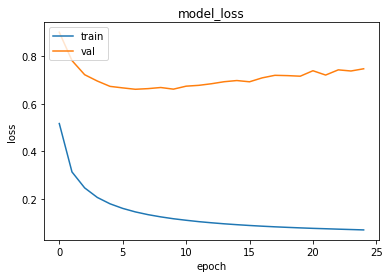

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model_loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

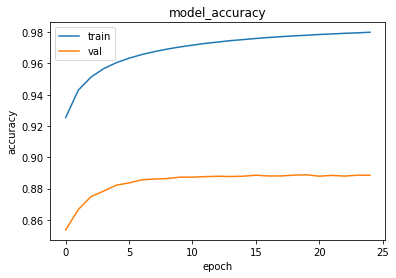

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model_accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Evaluation

In [ ]:
seq2seq_gru.evaluate(val_dataset)

     32/Unknown - 190s 5s/step - loss: 0.7100 - bleu_12: 0.4234

KeyboardInterrupt: ignored

## Testing

In [ ]:
index_to_word={x:y for x, y in zip(range(len(french_vectorize_layer.get_vocabulary())),
                                   french_vectorize_layer.get_vocabulary())}

In [ ]:
def translator(english_sentence):
  tokenized_english_sentence=english_vectorize_layer([english_sentence])
  shifted_target='starttoken'

  for i in range(FRENCH_SEQUENCE_LENGTH):
    tokenized_shifted_target=french_vectorize_layer([shifted_target])
    output=seq2seq_gru.predict([tokenized_english_sentence,tokenized_shifted_target])
    french_word_index=tf.argmax(output,axis=-1)[0][i].numpy()
    current_word=index_to_word[french_word_index]
    if current_word=='endtoken':
      break
    shifted_target+=' '+current_word
  return shifted_target[11:]

In [ ]:
translator('What makes you think that is not true?')

'questce que tu fais nest pas vrai'

In [ ]:
word_to_index={y:x for x, y in zip(range(len(french_vectorize_layer.get_vocabulary())),
                                   french_vectorize_layer.get_vocabulary())}

{'': 0, '[UNK]': 1, 'starttoken': 2, 'endtoken': 3, 'je': 4, 'de': 5, 'pas': 6, 'que': 7, 'ne': 8, 'à': 9, 'la': 10, 'le': 11, 'vous': 12, 'tom': 13, 'il': 14, 'est': 15, 'un': 16, 'a': 17, 'ce': 18, 'tu': 19, 'nous': 20, 'les': 21, 'une': 22, 'en': 23, 'jai': 24, 'pour': 25, 'suis': 26, 'me': 27, 'faire': 28, 'cest': 29, 'elle': 30, 'dans': 31, 'des': 32, 'plus': 33, 'qui': 34, 'tout': 35, 'te': 36, 'ça': 37, 'ma': 38, 'du': 39, 'fait': 40, 'avec': 41, 'mon': 42, 'se': 43, 'veux': 44, 'au': 45, 'si': 46, 'et': 47, 'sont': 48, 'cette': 49, 'quil': 50, 'y': 51, 'très': 52, 'son': 53, 'votre': 54, 'être': 55, 'sur': 56, 'pourquoi': 57, 'temps': 58, 'cela': 59, 'dit': 60, 'été': 61, 'était': 62, 'pense': 63, 'nest': 64, 'moi': 65, 'peux': 66, 'ils': 67, 'lui': 68, 'chose': 69, 'sais': 70, 'jamais': 71, 'nai': 72, 'ici': 73, 'comment': 74, 'où': 75, 'vraiment': 76, 'ton': 77, 'bien': 78, 'estce': 79, 'quelque': 80, 'dire': 81, 'tous': 82, 'par': 83, 'beaucoup': 84, 'êtes': 85, 'besoin': 86